<a href="https://colab.research.google.com/github/oraziotorre/MomentumShiftAI/blob/main/ModelsDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [27]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("tennis_2010-now.csv")

In [28]:
# Split 'Pts'
dataset[['Pt1_raw', 'Pt2_raw']] = dataset['Pts'].astype(str).str.split('-', expand=True)

# Set numerici
dataset['Gm1'] = pd.to_numeric(dataset['Gm1'], errors='coerce')
dataset['Gm2'] = pd.to_numeric(dataset['Gm2'], errors='coerce')

# Maschera tiebreak SOLO se 6-6
is_tiebreak = (dataset['Gm1'] == 6) & (dataset['Gm2'] == 6)

normal_score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
tiebreak_score_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, 'AD': 7}

pt1_normal = dataset['Pt1_raw'].map(normal_score_map)
pt2_normal = dataset['Pt2_raw'].map(normal_score_map)

pt1_tb = dataset['Pt1_raw'].map(tiebreak_score_map)
pt2_tb = dataset['Pt2_raw'].map(tiebreak_score_map)

dataset['Pt1'] = np.where(is_tiebreak, pt1_tb, pt1_normal)
dataset['Pt2'] = np.where(is_tiebreak, pt2_tb, pt2_normal)

# Definisci IsDeuce per game normale
normal_deuce = (
    (~is_tiebreak) &
    (
        ((dataset['Pt1'] == 3) & (dataset['Pt2'] == 3)) |   # 40-40
        ((dataset['Pt1'] == 3) & (dataset['Pt2'] == 4)) |   # 40-ADV
        ((dataset['Pt1'] == 4) & (dataset['Pt2'] == 3))     # ADV-40
    )
)

# Definisci IsDeuce per tiebreak
tiebreak_deuce = (
    (is_tiebreak) &
    (dataset['Pt1'] >= 6) &
    (dataset['Pt2'] >= 6) &
    (abs(dataset['Pt1'] - dataset['Pt2']) <= 1)
)

# Combina i due casi
dataset['IsDeuce'] = (normal_deuce | tiebreak_deuce).astype(int)

# Aggiungi colonna IsTieBreak
dataset['IsTieBreak'] = is_tiebreak.astype(int)

dataset.drop(columns=['Pt1_raw', 'Pt2_raw'], inplace=True)

In [29]:
print(dataset.iloc[1470:1505][['Pts', 'Set1', 'Set2', 'Pt1', 'Pt2', 'IsDeuce','IsTieBreak']])

        Pts  Set1  Set2  Pt1  Pt2  IsDeuce  IsTieBreak
1470    0-0     0     1  0.0  0.0        0           0
1471   0-15     0     1  0.0  1.0        0           0
1472  15-15     0     1  1.0  1.0        0           0
1473  30-15     0     1  2.0  1.0        0           0
1474  30-30     0     1  2.0  2.0        0           0
1475  40-30     0     1  3.0  2.0        0           0
1476  40-40     0     1  3.0  3.0        1           0
1477  AD-40     0     1  4.0  3.0        1           0
1478    0-0     0     1  0.0  0.0        0           0
1479   15-0     0     1  1.0  0.0        0           0
1480  15-15     0     1  1.0  1.0        0           0
1481  15-30     0     1  1.0  2.0        0           0
1482  30-30     0     1  2.0  2.0        0           0
1483  30-40     0     1  2.0  3.0        0           0
1484    0-0     0     1  0.0  0.0        0           1
1485    0-1     0     1  0.0  1.0        0           1
1486    1-1     0     1  1.0  1.0        0           1
1487    1-

In [30]:
dataset = dataset.drop(columns=['PointType','Pts'])#,'Player1','Player2','SetID', 'SetWinner','PtSet'

#**Train-Test split**

In [31]:
# Generazione delle partite inverse per aumentare la dimensione del dataset

def augment_with_symmetric(df: pd.DataFrame) -> pd.DataFrame:
    df_swapped = df.copy()

    # Colonne da swappare a coppie
    swap_pairs = [
        ('Set1', 'Set2'),
        ('Gm1', 'Gm2'),
        ('Pt1', 'Pt2'),
        ('Player1', 'Player2'),
        ('Ranking1', 'Ranking2'),
        ('p1_win_nobreak_point', 'p2_win_nobreak_point'),
        ('p1_win_break_point', 'p2_win_break_point'),
        ('p1_lost_nobreak_point', 'p2_lost_nobreak_point'),
        ('p1_lost_break_point', 'p2_lost_break_point'),
        ('serve_ace_1', 'serve_ace_2'),
        ('serve_miss2_1', 'serve_miss1_2'),
        ('rally_winner_1', 'rally_winner_2'),
        ('rally_forced2_1', 'rally_forced1_2'),
        ('rally_unforced1_2', 'rally_unforced2_1')
    ]
    for col1, col2 in swap_pairs:
        df_swapped[[col1, col2]] = df[[col2, col1]].values

    # Colonne dove 1 <-> 2
    invert_1_2_cols = ['Svr', 'PtWinner', 'SetWinner', 'MatchWinner']
    for col in invert_1_2_cols:
        df_swapped[col] = df[col].replace({1: 2, 2: 1})


    # Aggiunta del suffisso 'simm' a match_id e set_id, se presenti
    for col in ['match_id', 'SetID']:
        if col in df_swapped.columns:
            df_swapped[col] = df_swapped[col].astype(str) + '_simm'

    return pd.concat([df, df_swapped], ignore_index=True)

In [52]:
# 1️⃣ Scaling e Normalizzazione

def preprocess_data(train_data, test_data):
    # Copie di sicurezza
    train_data = train_data.copy()
    test_data = test_data.copy()

    # === 1. Colonne da trasformare ===
    minmax_cols = ['Gm1', 'Gm2', 'Pt1', 'Pt2']
    standard_cols = ['Ranking1', 'Ranking2']
    others = ['Svr', 'PtWinner','IsDeuce','IsTieBreak']

    # === 2. Altre feature da conservare (numeriche/categoriche già pronte) ===
    exclude_cols = minmax_cols + standard_cols + others + \
                   ['match_id', 'SetID', 'Player1', 'Player2', 'PtSet', 'SetWinner', 'MatchWinner']

    # === 3. Normalizzazione ===
    minmax_scaler = MinMaxScaler()
    train_data[minmax_cols] = minmax_scaler.fit_transform(train_data[minmax_cols])
    test_data[minmax_cols] = minmax_scaler.transform(test_data[minmax_cols])

    # === 4. Standardizzazione ===
    standard_scaler = StandardScaler()
    train_data[standard_cols] = standard_scaler.fit_transform(train_data[standard_cols])
    test_data[standard_cols] = standard_scaler.transform(test_data[standard_cols])

    feature_cols = minmax_cols + others

    # === 5. Target: conversione [1,2] → [0,1] ===
    target_cols = ['Svr', 'PtWinner', 'SetWinner', 'MatchWinner']
    for col in target_cols:
        train_data = train_data[train_data[col].isin([1, 2])]
        test_data = test_data[test_data[col].isin([1, 2])]
        train_data[col] = train_data[col].astype(int) - 1
        test_data[col] = test_data[col].astype(int) - 1

    # === 6. Conversione finale a float ===
    train_data[feature_cols] = train_data[feature_cols].astype(float)
    test_data[feature_cols] = test_data[feature_cols].astype(float)

    return train_data, test_data, feature_cols

In [53]:
# 2️⃣ Creazione sequenze

def create_sequences(data, feature_cols, target_col='SetWinner'):
    X_sequences = []
    y_labels = []
    lengths = []

    # Ordina i punti all'interno di ciascun match
    data = data.sort_values(['SetID', 'PtSet']).reset_index(drop=True)

    for match_id, df_match in data.groupby('SetID'):
        seq_data = df_match[feature_cols].to_numpy(dtype=np.float32)
        X_seq = torch.tensor(seq_data, dtype=torch.float32)
        X_sequences.append(X_seq)

        # Prende il target del primo punto del match (assunto costante per tutti)
        target_winner = int(df_match[target_col].iloc[0])
        y_labels.append(target_winner)
        lengths.append(len(df_match))

    # Padding delle sequenze
    X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)
    y_tensor = torch.tensor(y_labels, dtype=torch.float)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return X_padded, y_tensor, lengths

In [54]:
# 3️⃣ Pipeline completa + DataLoader

def collate_fn(batch):
    inputs, targets, lengths = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    lengths = torch.stack(lengths)
    sorted_idx = torch.argsort(lengths, descending=True)
    return inputs[sorted_idx], targets[sorted_idx], lengths[sorted_idx]

def prepare_datasets(train_data, test_data, target_col='SetWinner', batch_size=32):
    # Preprocessing dati
    train_proc, test_proc, feature_cols = preprocess_data(train_data, test_data)
    # Creazione sequenze
    X_train, y_train, train_lengths = create_sequences(train_proc, feature_cols, target_col)
    X_test, y_test, test_lengths = create_sequences(test_proc, feature_cols, target_col)

    # Costruzione dei TensorDataset
    train_dataset = TensorDataset(X_train, y_train, train_lengths)
    test_dataset = TensorDataset(X_test, y_test, test_lengths)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, test_loader, feature_cols

#**Model 1**

Epoch 1 - Loss: 0.2117
Epoch 2 - Loss: 0.0302
Epoch 3 - Loss: 0.0244
Epoch 4 - Loss: 0.0391
Epoch 5 - Loss: 0.0198
Epoch 6 - Loss: 0.0191
Epoch 7 - Loss: 0.0171
Epoch 8 - Loss: 0.0101
Epoch 9 - Loss: 0.0127
Epoch 10 - Loss: 0.0083
Epoch 11 - Loss: 0.0048
Epoch 12 - Loss: 0.0021
Epoch 13 - Loss: 0.0008
Epoch 14 - Loss: 0.0007
Epoch 15 - Loss: 0.0006
Epoch 16 - Loss: 0.0005
Epoch 17 - Loss: 0.0004
Epoch 18 - Loss: 0.0004
Epoch 19 - Loss: 0.0004
Epoch 20 - Loss: 0.0003
Epoch 21 - Loss: 0.0003
Epoch 22 - Loss: 0.0003
Epoch 23 - Loss: 0.0002
Epoch 24 - Loss: 0.0002
Epoch 25 - Loss: 0.0002
Epoch 26 - Loss: 0.0002
Epoch 27 - Loss: 0.0001
Epoch 28 - Loss: 0.0001
Epoch 29 - Loss: 0.0001
Epoch 30 - Loss: 0.0001
Epoch 31 - Loss: 0.0001
Epoch 32 - Loss: 0.0001
Epoch 33 - Loss: 0.0000
Epoch 34 - Loss: 0.0000
Epoch 35 - Loss: 0.0000
Epoch 36 - Loss: 0.0000
Epoch 37 - Loss: 0.0000
Epoch 38 - Loss: 0.0000
Epoch 39 - Loss: 0.0000
Epoch 40 - Loss: 0.0000
Epoch 41 - Loss: 0.0000
Epoch 42 - Loss: 0.0000
E

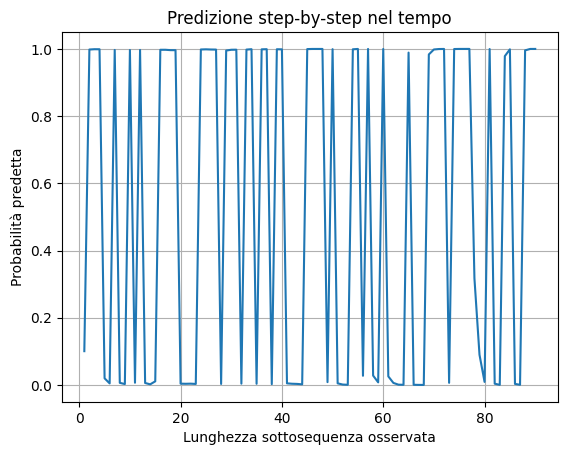

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
import math
import random
import matplotlib.pyplot as plt

# ---------- 1. MODELLO ----------

class LSTMPerStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.output_layer = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1))
        logits = self.output_layer(output)  # shape: (batch, seq_len, 1)
        probs = self.sigmoid(logits).squeeze(-1)  # shape: (batch, seq_len)
        return probs

# ---------- 2. FUNZIONI DI LOSS PERSONALIZZATE ----------

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def smooth_loss(y_pred, weight):
    delta = y_pred[1:] - y_pred[:-1]
    return torch.sum(delta**2) * weight

def weighted_loss(y_gt, y_pred, device, weighting=None, alpha=.9,
                  loss_fn=nn.BCELoss(reduction='none'), scaling='linear', smooth=False):
    weight = np.ones(y_gt.shape)
    m = weight.shape[1]

    for i in range(m):
        if weighting is None:
            if scaling == 'linear':
                w = i / m
            elif scaling == 'sigmoid':
                w = sigmoid((i - 3*m/4) * 10 / m)
            elif scaling == 'inverted_exponential_decay':
                w = 1 - (1 / ((99 / m) * i + 1))
            else:
                w = 1.0
        else:
            w = weighting
        weight[:, i] = max(w, 0.1)  # <-- evita pesi troppo piccoli

    weight = torch.from_numpy(weight).to(device)
    pointwise_loss = weight * loss_fn(y_pred, y_gt)

    # normalizza per la somma dei pesi validi
    norm_factor = torch.sum(weight)
    loss = torch.sum(pointwise_loss) / norm_factor

    if smooth:
        loss += smooth_loss(y_pred.squeeze(0), 3)

    return loss




def auto_weighted_loss(y_gt, y_pred, mask, mask_weight, loss_fn=nn.BCELoss(reduction='none')):
    pointwise_loss = torch.sum(mask * loss_fn(y_pred, y_gt))
    explainability_loss = torch.norm(1 - mask, p=2) * mask_weight
    #print("y_gt:", y_gt.shape, "y_pred:", y_pred.shape)
    return pointwise_loss + explainability_loss

# ---------- 3. TRAINING LOOP ----------

def train(model, dataloader, optimizer, device, loss_type='bce', use_smooth=False):
    model.train()
    total_loss = 0

    for X_batch, y_batch, lengths in dataloader:
        X_batch = X_batch.to(device)            # (batch, max_seq_len, input_size)
        y_batch = y_batch.to(device)            # (batch,)
        lengths = lengths.to(device)            # (batch,)

        optimizer.zero_grad()

        preds = model(X_batch, lengths)         # (batch, max_seq_len)

        y_expanded = y_batch.unsqueeze(1).expand_as(preds)  # (batch, max_seq_len)
        max_len = preds.size(1)
        mask = torch.arange(max_len, device=device)[None, :] < lengths[:, None]  # (batch, max_seq_len)

        if loss_type == 'weighted':
            # y_expanded e preds hanno shape (batch, seq_len)
            assert y_expanded.shape == preds.shape, f"Shape mismatch: {y_expanded.shape} vs {preds.shape}"
            loss = weighted_loss(y_expanded, preds, device, loss_fn=nn.BCELoss(reduction='none'), scaling='linear', smooth=use_smooth)
        elif loss_type == 'auto':
            # y_expanded e preds hanno shape (batch, seq_len)
            assert y_expanded.shape == preds.shape, f"Shape mismatch: {y_expanded.shape} vs {preds.shape}"
            loss = auto_weighted_loss(y_expanded, preds, mask.float(), mask_weight=0.1, loss_fn=nn.BCELoss(reduction='none'))
        else:
            loss = nn.BCELoss()(preds[mask], y_expanded[mask])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# ---------- 4. PREDIZIONE STEP-BY-STEP ----------

def predict_sequence_steps(model, X_seq, device):
    model.eval()
    X_seq = X_seq.unsqueeze(0).to(device)  # [1, seq_len, input_dim]
    seq_len = X_seq.size(1)
    probs = []

    with torch.no_grad():
        for t in range(1, seq_len + 1):
            input_subseq = X_seq[:, :t, :]
            lengths = torch.tensor([t], dtype=torch.long).to(device)
            output = model(input_subseq, lengths)  # output: [1, t]
            prob = output[0, -1].item()
            probs.append(prob)

            # Stampa delle feature e della predizione per ogni passo
            print(f"Passo {t}/{seq_len}:")
            print(f"Feature al passo {t}: {input_subseq[0, -1, :].cpu().numpy()}")  # Stampa l'ultima feature della sequenza fino al passo t
            print(f"Predizione al passo {t}: {prob:.4f}")
            print("-" * 40)

    return probs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 8
hidden_size = 64
batch_size = 32

model = LSTMPerStep(input_size=input_size, hidden_size=hidden_size, bidirectional=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Estrai tutti gli ID unici delle partite
match_ids = dataset['match_id'].unique()

# Split degli ID in training e test (es. 80% train, 20% test)
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)

# Split per match-id
train_data = dataset[dataset['match_id'].isin(train_ids)].reset_index(drop=True)
test_data = dataset[dataset['match_id'].isin(test_ids)].reset_index(drop=True)

#train_data = augment_with_symmetric(train_data)#############################
#test_data = augment_with_symmetric(test_data)###############################

train_loader, test_loader, feature_cols = prepare_datasets(train_data, test_data, target_col='SetWinner', batch_size=32)


for epoch in range(50):
    loss = train(model, train_loader, optimizer, device, loss_type='bce', use_smooth=True)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}")
X_batch, y_batch, lengths = next(iter(test_loader))
X_seq = X_batch[0]  # [seq_len, input_size]
y = y_batch[0]

print(f"Etichetta vera della sequenza: {int(y.item())}")
print(f"Lunghezza sequenza: {X_seq.shape[0]}  |  Dimensione feature: {X_seq.shape[1]}")
print("Prime 3 feature della sequenza (prime 5 righe):")
print(X_seq[:5, :3])

full_probs = predict_sequence_steps(model, X_seq[:lengths[0]], device)
final_prob = full_probs[-1]  # solo fino alla lunghezza reale

print(f"Probabilità predetta finale (con sequenza completa): {final_prob:.4f}")

plt.plot(range(1, len(full_probs)+1), full_probs)
plt.xlabel("Lunghezza sottosequenza osservata")
plt.ylabel("Probabilità predetta")
plt.title("Predizione step-by-step nel tempo")
plt.grid(True)
plt.show()



# **Model 2**

Etichetta vera della sequenza: 1
Lunghezza sequenza: 142  |  Dimensione feature: 8
Prime 3 feature della sequenza (prime 5 righe):
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1429],
        [0.0000, 0.0000, 0.1429],
        [0.0000, 0.0000, 0.2857],
        [0.0000, 0.0000, 0.4286]])
Passo 1/62:
Feature al passo 1: [0. 0. 0. 0. 0. 0. 0. 0.]
Predizione al passo 1: 0.5300
----------------------------------------
Passo 2/62:
Feature al passo 2: [0.         0.         0.14285715 0.         0.         1.
 0.         0.        ]
Predizione al passo 2: 0.6778
----------------------------------------
Passo 3/62:
Feature al passo 3: [0.         0.         0.14285715 0.14285715 0.         0.
 0.         0.        ]
Predizione al passo 3: 0.6558
----------------------------------------
Passo 4/62:
Feature al passo 4: [0.         0.         0.2857143  0.14285715 0.         0.
 0.         0.        ]
Predizione al passo 4: 0.6336
----------------------------------------
Passo 5/62:

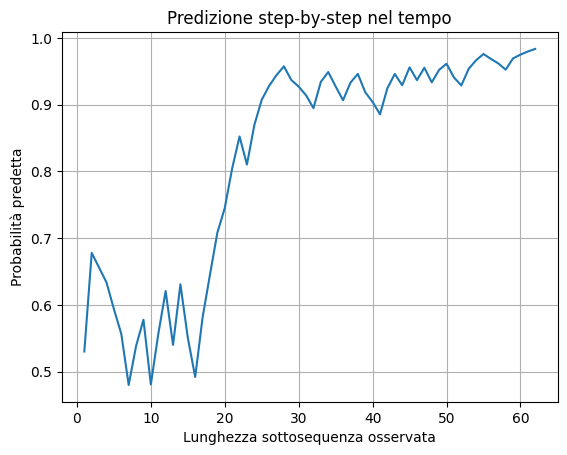

In [57]:
X_batch, y_batch, lengths = next(iter(test_loader))
X_seq = X_batch[10]  # [seq_len, input_size]
y = y_batch[10]

print(f"Etichetta vera della sequenza: {int(y.item())}")
print(f"Lunghezza sequenza: {X_seq.shape[0]}  |  Dimensione feature: {X_seq.shape[1]}")
print("Prime 3 feature della sequenza (prime 5 righe):")
print(X_seq[:5, :3])

# Predizione step-by-step
full_probs = predict_sequence_steps(model, X_seq[:lengths[10]], device)  # Utilizza la lunghezza effettiva della sequenza
final_prob = full_probs[-1]  # Solo fino alla lunghezza reale

print(f"Probabilità predetta finale (con sequenza completa): {final_prob:.4f}")

# Visualizzazione della probabilità nel tempo
plt.plot(range(1, len(full_probs)+1), full_probs)
plt.xlabel("Lunghezza sottosequenza osservata")
plt.ylabel("Probabilità predetta")
plt.title("Predizione step-by-step nel tempo")
plt.grid(True)
plt.show()